In [1]:
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 26.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
Compute dtype: float16
Variable dtype: float32


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [6]:
train_dir = "/content/drive/MyDrive/THESIS/image_data/Train_data"
test_dir = "/content/drive/MyDrive/THESIS/image_data/Test_data"

In [7]:
model1 = VGG16(include_top=False,input_shape=(256, 256, 3), weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
input_shape = (256,256)

In [9]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 32
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 1701 images belonging to 11 classes.
Found 726 images belonging to 11 classes.


In [10]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [11]:
headModel = model1.output
headModel = layers.Flatten()(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(11, activation="softmax")(headModel)
model = Model(inputs=model1.input, outputs=headModel)

In [12]:
optimizer = Adam(lr=1e-5)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
steps_per_epoch = generator_train.n/batch_size
steps_test = generator_test.n/batch_size
history = model.fit_generator(generator=generator_train,
                                  epochs=50,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
53/53 [==============================] - 1697s 31s/step - loss: 2.6359 - categorical_accuracy: 0.0829 - val_loss: 2.3977 - val_categorical_accuracy: 0.0937
Epoch 2/50
53/53 [==============================] - 41s 772ms/step - loss: 2.4950 - categorical_accuracy: 0.0923 - val_loss: 2.3840 - val_categorical_accuracy: 0.1240
Epoch 3/50
53/53 [==============================] - 41s 776ms/step - loss: 2.3880 - categorical_accuracy: 0.1164 - val_loss: 2.2571 - val_categorical_accuracy: 0.1474
Epoch 4/50
53/53 [==============================] - 42s 778ms/step - loss: 2.2234 - categorical_accuracy: 0.1793 - val_loss: 2.0359 - val_categorical_accuracy: 0.2769
Epoch 5/50
53/53 [==============================] - 41s 774ms/step - loss: 2.0564 - categorical_accuracy: 0.2022 - val_loss: 1.8499 - val_categorical_accuracy: 0.2906
Epoch 6/50
53/53 [==============================] - 41s 774ms/step - loss: 1.9034 - categorical_accuracy: 0.2640 - val_loss: 1.7751 - val_categorical_accuracy: 0.305

In [14]:
final_loss, final_acc = model.evaluate(  generator_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.317403, final accuracy: 0.907713


In [15]:
generator_train.class_indices

{'class_0': 0,
 'class_1': 1,
 'class_10': 2,
 'class_2': 3,
 'class_3': 4,
 'class_4': 5,
 'class_5': 6,
 'class_6': 7,
 'class_7': 8,
 'class_8': 9,
 'class_9': 10}

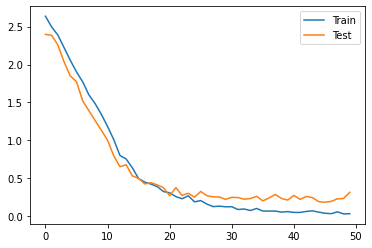

In [17]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()